In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/email-spam-classification/email_spam.csv


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re

2025-05-18 13:55:48.994735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747576549.230182      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747576549.293829      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Load data
data = pd.read_csv('/kaggle/input/email-spam-classification/email_spam.csv')

# Check columns
print(data.columns)
data.head()

Index(['title', 'text', 'type'], dtype='object')


,title,text,type
0,?? the secrets to SUCCESS,"Hi James,\n\nHave you claim your complimentary...",spam
1,?? You Earned 500 GCLoot Points,"\nalt_text\nCongratulations, you just earned\n...",not spam
2,?? Your GitHub launch code,"Here's your GitHub launch code, @Mortyj420!\n ...",not spam
3,[The Virtual Reward Center] Re: ** Clarifications,"Hello,\n \nThank you for contacting the Virtua...",not spam
4,"10-1 MLB Expert Inside, Plus Everything You Ne...","Hey Prachanda Rawal,\n\nToday's newsletter is ...",spam


In [6]:
# Combine 'title' and 'text'
data['TEXT'] = data['title'].astype(str) + ' ' + data['text'].astype(str)

# Preprocessing function
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

data['TEXT'] = data['TEXT'].apply(preprocess_text)


In [7]:
# Encode labels from 'type'
label_encoder = LabelEncoder()
data['Label_encoded'] = label_encoder.fit_transform(data['type'])
num_classes = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)

Classes: ['not spam' 'spam']


In [8]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    data['TEXT'], data['Label_encoded'], test_size=0.2, random_state=42, stratify=data['Label_encoded']
)

In [11]:
# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
max_len = 300
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

vocab_size = len(tokenizer.word_index) + 1


In [14]:
# RNN model
rnn_model = Sequential([
    Embedding(vocab_size, 64, input_length=max_len),
    SimpleRNN(64),
    Dense(num_classes, activation='softmax')
])
rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print("Training RNN model...")
rnn_history = rnn_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))


Training RNN model...
Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 432ms/step - accuracy: 0.3231 - loss: 0.7140 - val_accuracy: 0.5882 - val_loss: 0.6686
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.6968 - loss: 0.6117 - val_accuracy: 0.7059 - val_loss: 0.6469
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7072 - loss: 0.6157 - val_accuracy: 0.7059 - val_loss: 0.6605
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7020 - loss: 0.6142 - val_accuracy: 0.5294 - val_loss: 0.7445
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7072 - loss: 0.5825 - val_accuracy: 0.5294 - val_loss: 0.6940


In [15]:
# LSTM model
lstm_model = Sequential([
    Embedding(vocab_size, 64, input_length=max_len),
    LSTM(64),
    Dense(num_classes, activation='softmax')
])
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print("\nTraining LSTM model...")
lstm_history = lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))



Training LSTM model...
Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 466ms/step - accuracy: 0.6665 - loss: 0.6786 - val_accuracy: 0.7059 - val_loss: 0.6664
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.6817 - loss: 0.6538 - val_accuracy: 0.7059 - val_loss: 0.6555
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.6869 - loss: 0.6341 - val_accuracy: 0.7059 - val_loss: 0.6558
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6869 - loss: 0.6272 - val_accuracy: 0.7059 - val_loss: 0.6732
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.6817 - loss: 0.6394 - val_accuracy: 0.7059 - val_loss: 0.7126


In [16]:
# Build BiLSTM model
bilstm_model = Sequential([
    Embedding(vocab_size, 64, input_length=max_len),
    Bidirectional(LSTM(64)),
    Dense(num_classes, activation='softmax')
])

bilstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print("\nTraining BiLSTM model...")
bilstm_history = bilstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))



Training BiLSTM model...
Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3937 - loss: 0.7002 - val_accuracy: 0.7059 - val_loss: 0.6717
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6869 - loss: 0.6631 - val_accuracy: 0.7059 - val_loss: 0.6553
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6869 - loss: 0.6385 - val_accuracy: 0.7059 - val_loss: 0.6445
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6817 - loss: 0.6210 - val_accuracy: 0.7059 - val_loss: 0.6421
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6921 - loss: 0.6057 - val_accuracy: 0.7059 - val_loss: 0.6440


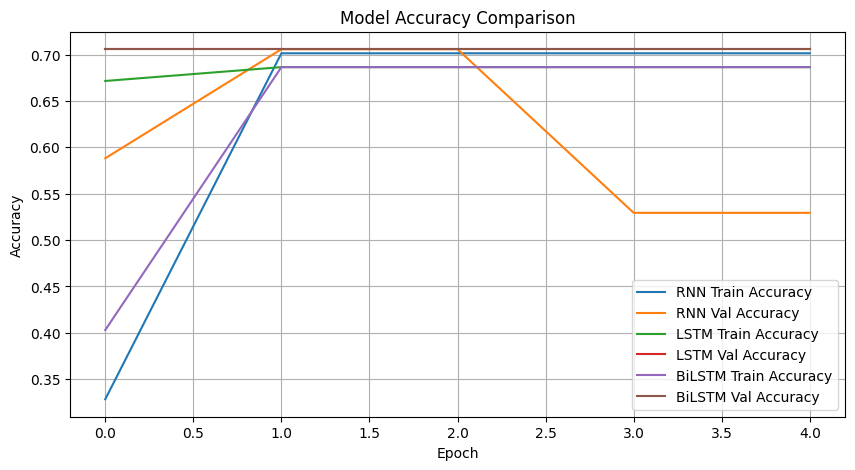

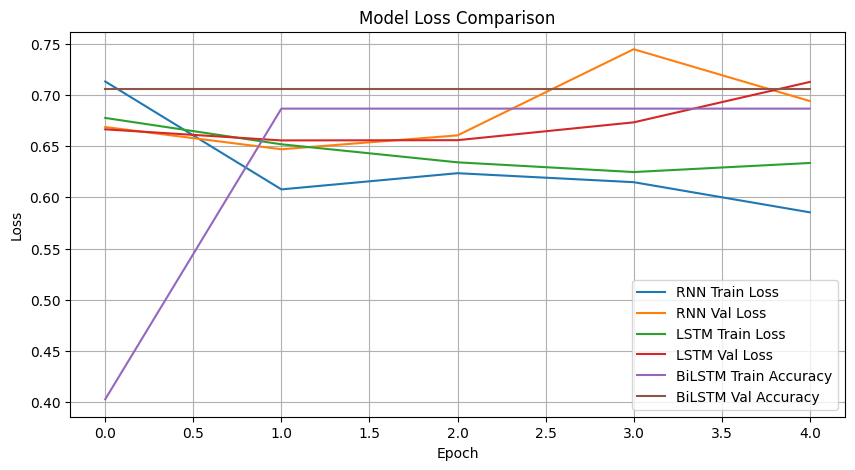

In [17]:
# Plotting Accuracy
plt.figure(figsize=(10,5))
plt.plot(rnn_history.history['accuracy'], label='RNN Train Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='RNN Val Accuracy')
plt.plot(lstm_history.history['accuracy'], label='LSTM Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Val Accuracy')
plt.plot(bilstm_history.history['accuracy'], label='BiLSTM Train Accuracy')
plt.plot(bilstm_history.history['val_accuracy'], label='BiLSTM Val Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plotting Loss
plt.figure(figsize=(10,5))
plt.plot(rnn_history.history['loss'], label='RNN Train Loss')
plt.plot(rnn_history.history['val_loss'], label='RNN Val Loss')
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val Loss')
plt.plot(bilstm_history.history['accuracy'], label='BiLSTM Train Accuracy')
plt.plot(bilstm_history.history['val_accuracy'], label='BiLSTM Val Accuracy')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()